In [1]:
# standard libraries
import importlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import linalg, stats, optimize
import time
from copy import deepcopy
from lib_neurips import error, create_K, sinkhorn_em_algorithm_single, em_algorithm_single
import sys
sys.path.append('/Users/francescacrucinio/Documents/MD_LVM')

import md_lvm
importlib.reload(md_lvm)

<module 'md_lvm' from '/Users/francescacrucinio/Documents/MD_LVM/md_lvm.py'>

In [2]:
theta = 1
ndata = 1000

In [3]:
Niter = 100
gamma = 0.05
props = np.linspace(0.5,1,51)

#number of repetitions in experiment
nrep = 10
mu_final_em = np.zeros((len(props), nrep, Niter))
mu_final_em_theta = np.zeros((len(props), nrep, Niter))
mu_final_sinkhorn = np.zeros((len(props), nrep, Niter))
theta_em = np.zeros((len(props),nrep,Niter,2))
mu_md = np.zeros((len(props),nrep,Niter))
times_em = np.zeros((len(props), nrep))
times_oem = np.zeros((len(props), nrep))
times_sem = np.zeros((len(props), nrep))
times_md = np.zeros((len(props), nrep))

In [4]:
for r in range(nrep):
    X0 = np.random.randn(ndata, 1).astype('float32')
    for p0 in range(len(props)): 
        prop = props[p0]
        X = deepcopy(X0)
        X[:int(ndata*prop), 0] += theta
        X[int(ndata*prop):ndata, 0] += -theta
        
        theta0 = np.reshape(np.array([prop, 1-prop]), [2,1])

        log_theta = np.zeros((2,1))
        log_theta[0] = np.log(prop)
        log_theta[1] = np.log(1-prop)
            
        mu00  = np.reshape(np.array([-2, 2]), [2,1]).astype('float32')
        
        start = time.time()
        a,b,seq = em_algorithm_single(X, mu00, 1, log_theta, n_iter=Niter, update_theta=False)
        end = time.time()
        times_em[p0,r] = end-start
        for n in range(Niter):
            mu_final_em[p0,r,n] = seq[n][0,0]

        start = time.time()
        a,b,seq = em_algorithm_single(X, mu00, 1, log_theta, n_iter=Niter, update_theta=True)
        end = time.time()
        times_oem[p0,r] = end-start
        for n in range(Niter):
            mu_final_em_theta[p0,r,n] = seq[n][0,0]            
            
        start = time.time()    
        a,theta0,seq=sinkhorn_em_algorithm_single(X, mu00, 1, log_theta, n_iter=Niter, n_iter_sinkhorn=200)
        end = time.time()
        times_sem[p0,r] = end-start    
            
        for n in range(Niter):
            mu_final_sinkhorn[p0,r,n] = seq[n][0,0]
            
        start = time.time()
        mu_md[p0, r, :],_,_ = md_lvm.md_gmm_fast(X.flatten(), gamma, Niter, ndata, -2, 2*np.random.binomial(1, 0.5, ndata)-1, prop)
        end = time.time()
        times_md[p0,r] = end-start

/var/folders/yb/2yx4lkb90l57vb9ljkzffpq40000gn/T/ipykernel_12031/3717286106.py:13: RuntimeWarning: divide by zero encountered in log
  log_theta[1] = np.log(1-prop)
/Users/francescacrucinio/Documents/MD_LVM/lib_neurips.py:38: RuntimeWarning: divide by zero encountered in log
  log_theta0 = np.log(theta0)
/Users/francescacrucinio/Documents/MD_LVM/lib_neurips.py:78: RuntimeWarning: divide by zero encountered in log
  u = eps * (np.log(mu_x) - logsumexp(M, axis=1)) + u
/Users/francescacrucinio/Documents/MD_LVM/lib_neurips.py:78: RuntimeWarning: invalid value encountered in subtract
  u = eps * (np.log(mu_x) - logsumexp(M, axis=1)) + u
/Users/francescacrucinio/Documents/MD_LVM/lib_neurips.py:82: RuntimeWarning: divide by zero encountered in log
  u = eps * (np.log(mu_x) - logsumexp(M, axis=1)) + u
/Users/francescacrucinio/Documents/MD_LVM/md_lvm.py:196: RuntimeWarning: divide by zero encountered in log
  ll = -(y-theta*x)**2/2-0.5*np.log(2*np.pi) +np.log((x==-1)+alpha*x)
/Users/francescacr

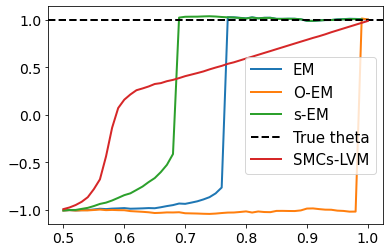

In [8]:
plt.plot(props,mu_final_em[:,0,-1],label='EM', linewidth=2)
plt.plot(props,mu_final_em_theta[:,0,-1],label='O-EM', linewidth=2)
plt.plot(props,mu_final_sinkhorn[:,0,-1],label='s-EM', linewidth=2)
plt.axhline(y=theta, c = 'black', linestyle = 'dashed', lw = 2, label = 'True theta')
plt.plot(props,mu_md[:,0,-1],label='SMCs-LVM', linewidth=2)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig('gaussian_mixture_full.pdf', bbox_inches="tight")

In [7]:
np.mean(times_md), np.mean(times_em), np.mean(times_oem), np.mean(times_sem)

(1.6348386278339462,
 0.0092239356508442,
 0.0183103926041547,
 1.6144307206658757)